In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#run pipeline - creates and populates image directories
#%run -i 'aws_jpg_directory_pipeline.py'   

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/core/magics/execution.py:728: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exit_ignore=exit_ignore)


In [6]:
import pathlib
data_dir = pathlib.Path('JMWT_vs_Other')

In [2]:
len_JMWT = len(os.listdir('JMWT_vs_Other/By JMWT'))
len_Other = len(os.listdir('JMWT_vs_Other/By another artist'))
print(f'JMWT length = {len_JMWT}')
print(f'Other artist length = {len_Other}')
difference = len_JMWT - len_Other
print(f'Subtract {difference} from JMWT. (Are already randomized)')

JMWT length = 2163
Other artist length = 2050
Subtract 113 from JMWT. (Are already randomized)


In [3]:
for file in os.listdir('JMWT_vs_Other/By JMWT')[:113]:
    path = f'JMWT_vs_Other/By JMWT/{file}'
    os.remove(path)

In [4]:
len_JMWT = len(os.listdir('JMWT_vs_Other/By JMWT'))
len_Other = len(os.listdir('JMWT_vs_Other/By another artist'))
print(f'JMWT length = {len_JMWT}')
print(f'Other artist length = {len_Other}')
difference = len_JMWT - len_Other
print(f'Subtract {difference} from JMWT. (Are already randomized)')

JMWT length = 2050
Other artist length = 2050
Subtract 0 from JMWT. (Are already randomized)


In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

4100

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4100 files belonging to 2 classes.
Using 3280 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4100 files belonging to 2 classes.
Using 820 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['By JMWT', 'By another artist']


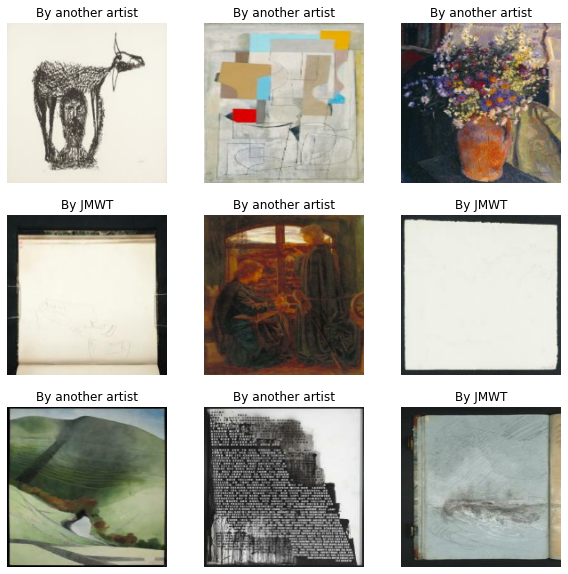

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.010887895 0.9711874


In [17]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
103/103 [==============================] - 196s 25ms/step - loss: 0.5177 - accuracy: 0.7660 - val_loss: 0.3237 - val_accuracy: 0.8476
Epoch 2/10
103/103 [==============================] - 1s 8ms/step - loss: 0.2687 - accuracy: 0.8725 - val_loss: 0.2792 - val_accuracy: 0.8659
Epoch 3/10
103/103 [==============================] - 1s 8ms/step - loss: 0.2240 - accuracy: 0.9031 - val_loss: 0.3133 - val_accuracy: 0.8744
Epoch 4/10
103/103 [==============================] - 1s 8ms/step - loss: 0.2297 - accuracy: 0.8985 - val_loss: 0.2838 - val_accuracy: 0.8646
Epoch 5/10
103/103 [==============================] - 1s 8ms/step - loss: 0.1752 - accuracy: 0.9300 - val_loss: 0.2336 - val_accuracy: 0.9134
Epoch 6/10
103/103 [==============================] - 1s 8ms/step - loss: 0.1656 - accuracy: 0.9341 - val_loss: 0.2696 - val_accuracy: 0.8841
Epoch 7/10
103/103 [==============================] - 1s 8ms/step - loss: 0.1651 - accuracy: 0.9284 - val_loss: 0.2483 - val_accuracy: 0.9134
Epo

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()